# [PLACEMENTIQ1] - Data exploration and validation dataset making

## 1 - Python stuff

In [1]:
import io
import os
import json
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 2 - Retrive the dataset

### 2.1 - AWS S3 config

In [2]:
with open("access_token.json", "rb") as file:
    token = json.load(file)

In [3]:
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = token["aws_access_key_id"],
    aws_secret_access_key = token["aws_secret_access_key"],
)

In [4]:
bucket_name = "mlelements"
prefix = "datasets/"
filename_train = "campus_selection.csv"

### 2.2 - Opening the dataset

In [5]:
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename_train)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        df = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
print(f"The dimension of the dataset : {df.shape}")

The dimension of the dataset : (215, 14)


In [7]:
df.head()

sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1      M  67.00   Others  91.00   Others  Commerce     58.00   
1      2      M  79.33  Central  78.33   Others   Science     77.48   
2      3      M  65.00  Central  68.00  Central      Arts     64.00   
3      4      M  56.00  Central  52.00  Central   Science     52.00   
4      5      M  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed

## 3 - Data exploration

### 3.1 - Quick overview

In [8]:
df.describe()

sl_no       ssc_p       hsc_p    degree_p     etest_p       mba_p
count  215.000000  215.000000  215.000000  215.000000  215.000000  215.000000
mean   108.000000   67.303395   66.333163   66.370186   72.100558   62.278186
std     62.209324   10.827205   10.897509    7.358743   13.275956    5.833385
min      1.000000   40.890000   37.000000   50.000000   50.000000   51.210000
25%     54.500000   60.600000   60.900000   61.000000   60.000000   57.945000
50%    108.000000   67.000000   65.000000   66.000000   71.000000   62.000000
75%    161.500000   75.700000   73.000000   72.000000   83.500000   66.255000
max    215.000000   89.400000   97.700000   91.000000   98.000000   77.890000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
dtypes: float64(5), int64(1), object(8)
memory usage: 23.6+ KB


### 3.2 - Numerical view

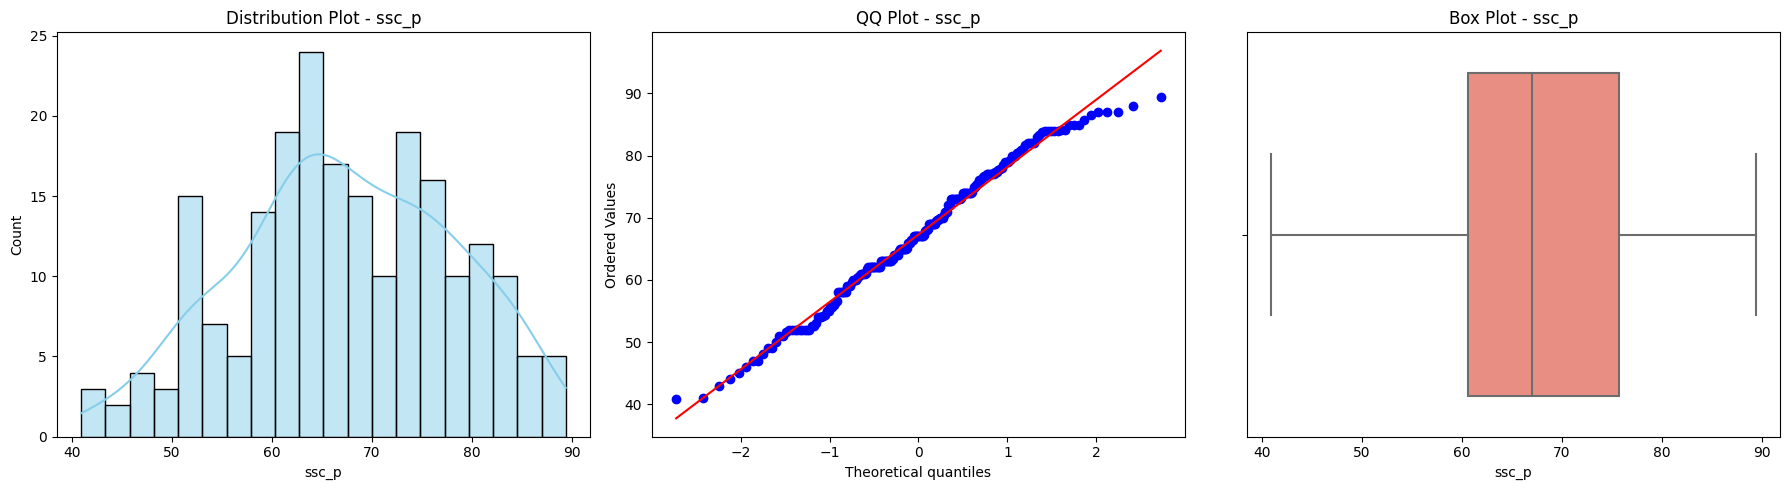

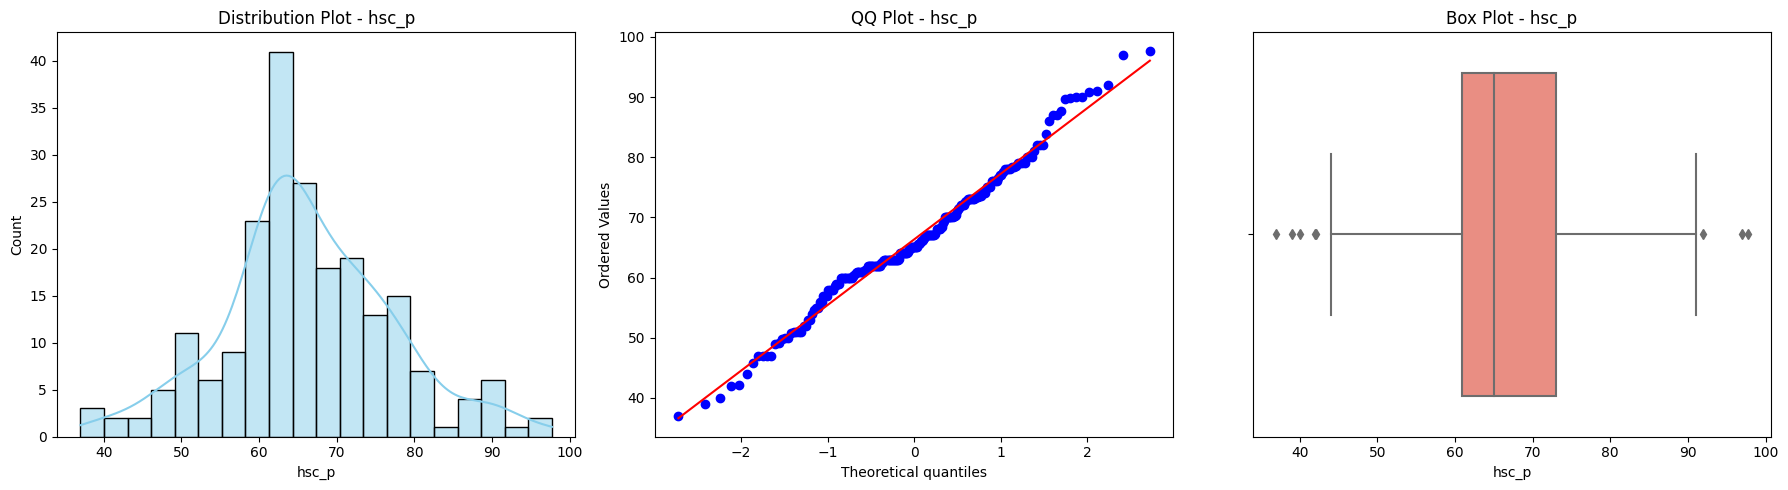

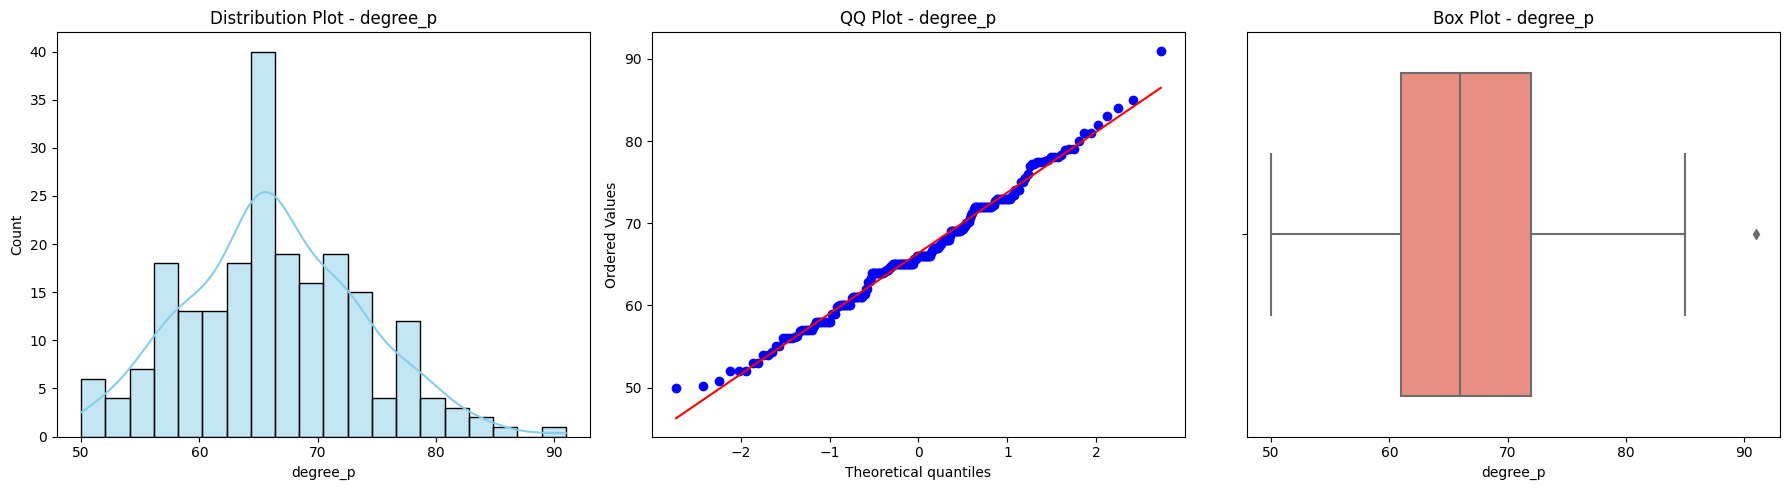

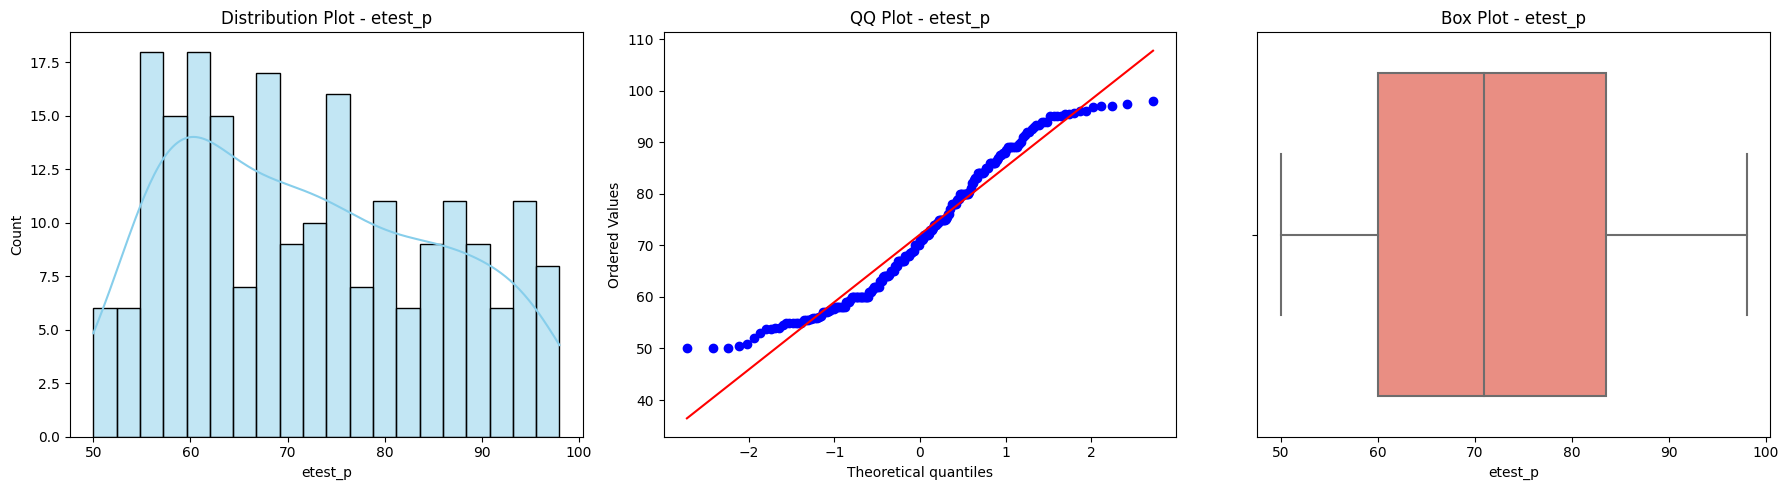

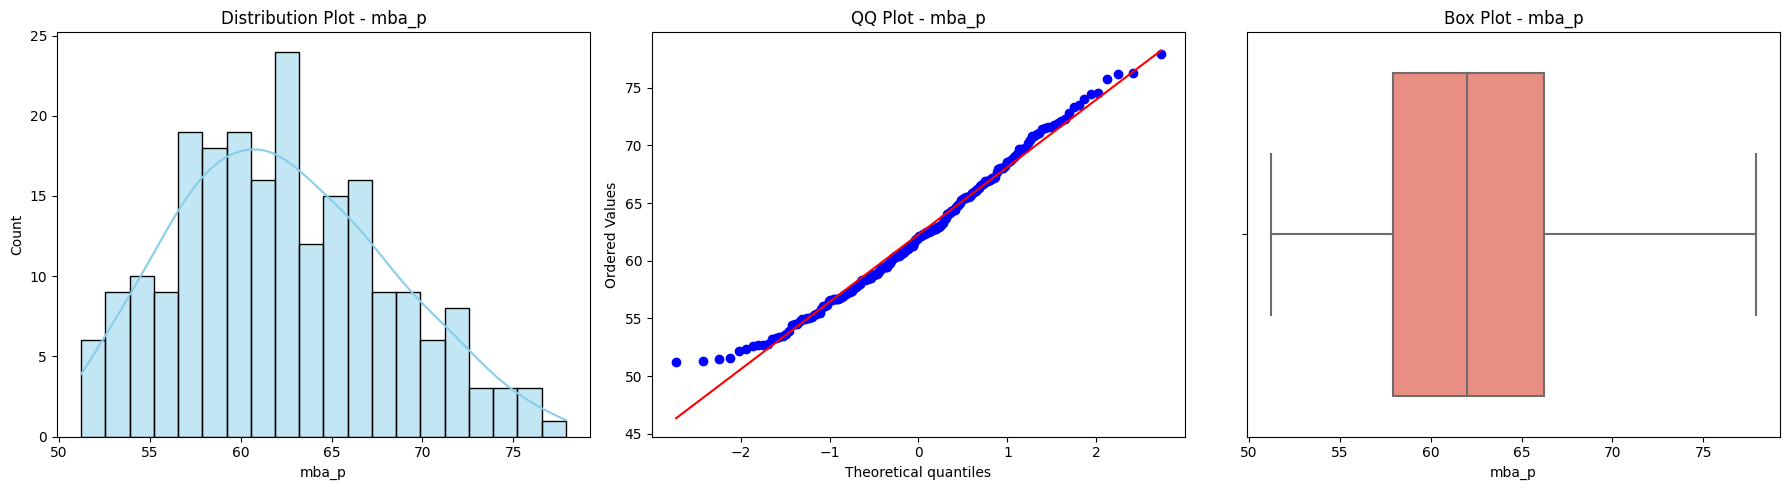

In [10]:
numerical_features = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

for feature in numerical_features:
    plt.figure(figsize=(18, 5))
    
    # Distribution plot
    plt.subplot(1, 3, 1)
    sns.histplot(df[feature], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution Plot - {feature}')
    
    # QQ plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'QQ Plot - {feature}')
    
    # Box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[feature], color='salmon')
    plt.title(f'Box Plot - {feature}')
    
    plt.tight_layout()
    plt.show()

## 4 - Cleaning and splitting and export in AWS S3

In [11]:
print("Null data :")
print("- - - " * 3)
df.isna().sum()

Null data :
- - - - - - - - - 


sl_no             0
gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
status            0
dtype: int64

> No cleaning strategy needed, no null data seeing 

In [12]:
# prepare for classification task
status_map = {"Placed": 0, "Not Placed": 1}
df["status"] = df["status"].map(status_map)

In [13]:
df.head(3)

sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1      M  67.00   Others  91.00   Others  Commerce     58.00   
1      2      M  79.33  Central  78.33   Others   Science     77.48   
2      3      M  65.00  Central  68.00  Central      Arts     64.00   

    degree_t workex  etest_p specialisation  mba_p  status  
0   Sci&Tech     No     55.0         Mkt&HR  58.80       0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28       0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80       0

In [14]:
df = df.sample(frac=1., axis=0)
df_train = df.sample(frac=.9767, axis=0)
df_validation = df.drop(df_train.index)

In [15]:
print("After splitting :")
print("- - - " * 3)
print(f"Data train : {df_train.shape}")
print(f"Data validation : {df_validation.shape}")

After splitting :
- - - - - - - - - 
Data train : (210, 14)
Data validation : (5, 14)


In [16]:
filename_train = "cleaned_campus_selection_train.csv"
filename_validation = "cleaned_campus_selection_validation.csv"

In [17]:
df_train.to_csv(prefix + filename_train, encoding="utf8", index=False)
df_validation.to_csv(prefix + filename_validation, encoding="utf8", index=False)

In [18]:
s3.upload_file(prefix + filename_train, bucket_name, prefix + filename_train)
s3.upload_file(prefix + filename_validation, bucket_name, prefix + filename_validation)

In [19]:
os.chdir("datasets")
os.remove(filename_train)
os.remove(filename_validation)
print("Datasets : ")
print("- - - " * 3)
if len(os.listdir()) > 1:
    for file in os.listdir():
        if file.endswith("csv") or file.endswith("txt"):
            print(file)
else: 
    print("You'll retreive all datasets in AWS S3 !")
    
os.chdir("../")

Datasets : 
- - - - - - - - - 
You'll retreive all datasets in AWS S3 !
